---
### Simplified System of linear equations solving for image $X$

Key terms:

$L$ = one-dimensional size for high-resolution image

$M$ = one-dimensional size for low-resolution image

$X$ = $L^2 \times 1$ column vector, represents the ideal image we are trying to recover via solving

$Y_i$ = $M^2 \times 1$ column vector, represents a decimated, downsampled, blurred, noisy image based on $X$

$N$ = the number of low-resolution images

$D$ = the decimation matrix operator of size $M^2 \times L^2$

$H$ = the blur matrix operator of size $L^2 \times L^2$

$S$ = the sharpening operator of size $L^2 \times L^2$, i.e., the laplacian operator

$w_i$ = a weighting scalar, a "confidence factor" for each $Y_i$ (eventually a diagonal matrix?)

$\beta$ = smoothing factor for controlling image sharpening

---

Objective: to solve for $X$ (i.e., $AX = B$) based on the following equation:

$\begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}X = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

---

General information:

- Dataset: GLEAM Small
- Timesteps: 30
- Receivers: 512
- Channels: 1
- $L$ = 100 pixels
- $M$ = 50 pixels
- $N$ = 6 images (30 timesteps / 5 timesteps per image)
- $w_i$ = 1 for all images
- $\beta$ = 1 (I guess?)

Asumptions:
1. The blur kernel $H$ is uniform across all instances of $Y$
2. The decimatimation kernel $D$ is uniform across all instances of $Y$
3. The $w_i$ is uniform across all instances of $Y$, just a confidence of 1.0 ("full confidence")

---

To do:

- [x] Generate 6 dataset subsets, containing timesteps each (i.e., 30 time steps / 5 time steps per file)
- [x] Generate one point spread function per dataset subset, for analysis of different
- [x] Generate one point spread function for the whole dataset
- [x] Determine if there is a significant difference between a subset PSF and the full dataset PSF - this will be the blur kernel
- [ ] Determine if the PSF can be reduced (i.e., dont use the full PSF) - what effects might this have?
- [x] Generate an IDFT of the full dataset, $L^2$ pixels
- [x] Genetate an IDFT for each of the subsets, $M^2$ pixels
- [x] Come up with a formula for populating the decimation matrix
- [ ] Come up with a formula for populating the blur matrix 
- [ ] Determine if there is a formula for populating the product of the blur and decimation matrix, such that $H^TD^T = (HD)^T$

---

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

def show_image(image, title):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def decimation_matrix(l, m):
    d_matrix = np.zeros((m**2, l**2))

    tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
    t_len = tile.shape[0]
    d = l // m
    r_offset = m**2 // 2
    c_offset = l**2 // 2

    for p in np.arange(l//4): # divide by 4 as 4 neighbours total
        p_offset = p * l
        for q in np.arange(m):
            d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
            d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
    return d_matrix

Configuration and data set up...

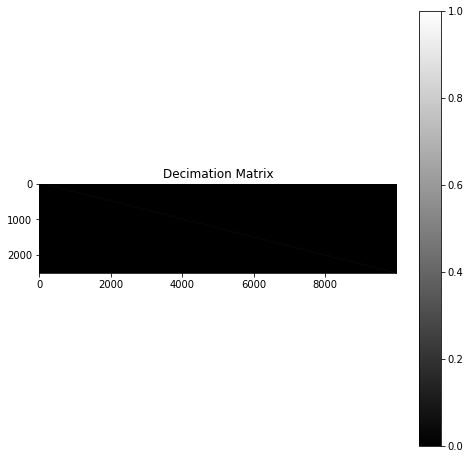

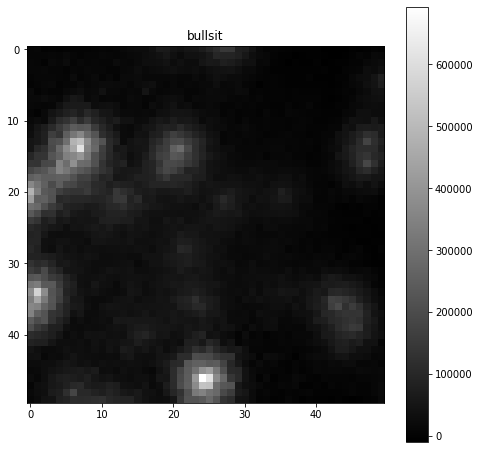

In [9]:
timesteps = 30 # total timesteps
timesteps_per_y = 5
L = 100
M = 50
N = timesteps // timesteps_per_y
β = 1.0 # no smoothing influence
w = 1.0 # full confidence

# all time steps direct image
filename = "../data/direct_image_ts_0_29.bin"
X_true = np.fromfile(filename, dtype=np.float32)
X_true = X_true.reshape(L, L)
# show_image(X_true, "True X")

# all time steps direct psf
filename = "../data/direct_psf_ts_0_29.bin"
X_psf = np.fromfile(filename, dtype=np.float32)
X_psf = X_psf.reshape(L, L)
# show_image(X_psf, "X PSF")

# Storing all low-res images as column vectors (num images, num pixels per image)
Y = np.zeros((N, M**2))

# batched time steps direct images
for i in np.arange(N):
    start = i * timesteps_per_y
    end = start + timesteps_per_y - 1
    filename = "../data/direct_image_ts_%d_%d.bin" % (start, end)
    Y[i] = np.fromfile(filename, dtype=np.float32)
    # show_image(Y[i].reshape(M, M), "$Y_{%d}$" % i)

Y = Y.T # flip so Y is a column vector matrix where Y_i is the ith image of L^2 x 1 pixels
    
# batched time steps point spread functions
# for i in np.arange(N):
#     start = i * timesteps_per_y
#     end = start + timesteps_per_y - 1
#     filename = "../data/direct_psf_ts_%d_%d.bin" % (start, end)
#     Y_i_psf = np.fromfile(filename, dtype=np.float32)
#     Y_i_psf = Y_i_psf.reshape(L, L)
#     # show_image(Y_i_psf, "$Y_{%d}$ PSF" % i)

# Decimation matrix
D = decimation_matrix(L, M)

# Blur matrix (psf)
H = np.zeros((L**2, L**2))

# Sharpening matrix (laplacian)
S = np.zeros((L**2, L**2))

Setting up the right hand side of the equation $AX = B$, where $B = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

Setting up the right hannd side of the equation $AX=B$, where $A = \begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}$

Now solve for $X$...